In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np


with open("C:/Users/golds/Desktop/Vectorial Encodings/random_news_500.txt", "r", encoding="utf-8") as f:
    texts = [line.strip() for line in f if line.strip()]


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def encode_bert(texts):
    vectors = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=32)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        vectors.append(cls_embedding)
    return np.array(vectors)

X_bert = encode_bert(texts)
np.save("C:/Users/golds/Desktop/Vectorial Encodings/X_bert.npy", X_bert)


c:\Users\golds\miniconda3\envs\torch_pig\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
from som_numba import NumbaSOM

som = NumbaSOM(x=20, y=20, input_len=768)
som.train(X_bert, num_iteration=10000)

import pickle
with open("C:/Users/golds/Desktop/Vectorial Encodings/som_bert_best.pkl", "wb") as f:
    pickle.dump(som, f)


📄 共加载 500 条文本
🔍 加载 BERT 模型...
📂 已加载现有向量: C:\Users\golds\Desktop\作业julian\X_bert.npy
🚀 开始训练 SOM...
✅ SOM 训练完成
💾 SOM 保存至: C:\Users\golds\Desktop\作业julian\som_bert_best.pkl


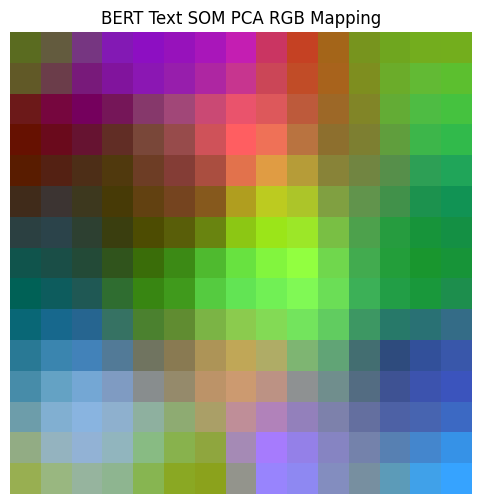

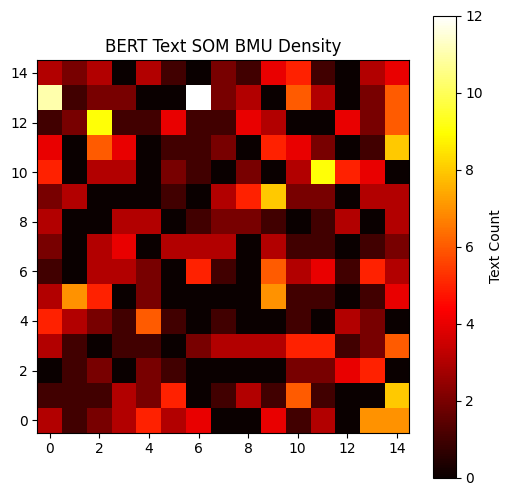

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertModel
from som_numba import NumbaSOM
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle


text_path = r"C:\Users\golds\Desktop\Vectorial Encodings\random_news_500.txt"
bert_vec_path = r"C:\Users\golds\Desktop\Vectorial Encodings\X_bert.npy"
som_save_path = r"C:\Users\golds\Desktop\Vectorial Encodings\som_bert_best.pkl"


with open(text_path, "r", encoding="utf-8") as f:
    texts = [line.strip() for line in f if line.strip()]
print(f"📄 共加载 {len(texts)} 条文本")


print("loading BERT tokenizer and model...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def encode_bert(texts):
    vectors = []
    for text in tqdm(texts, desc="coding BERT"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=32)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            cls_emb = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        vectors.append(cls_emb)
    return np.array(vectors)

if not os.path.exists(bert_vec_path):
    X_bert = encode_bert(texts)
    np.save(bert_vec_path, X_bert)
    print(f"✅ save: {bert_vec_path}")
else:
    X_bert = np.load(bert_vec_path)
    print(f"📂 loading: {bert_vec_path}")


print("🚀 train SOM...")
som = NumbaSOM(x=15, y=15, input_len=X_bert.shape[1])
som.train(X_bert, num_iteration=10000)
print("✅ SOM train complete")


with open(som_save_path, "wb") as f:
    pickle.dump(som, f)
print(f"💾 SOM save to: {som_save_path}")


def plot_som_rgb(som, X_data=None, title="SOM RGB Mapping"):
    weights = som.weights.reshape(-1, som.input_len)
    if X_data is not None:
        pca = PCA(n_components=3).fit(X_data)
    else:
        pca = PCA(n_components=3).fit(weights)
    rgb = pca.transform(weights)
    rgb = (rgb - rgb.min(0)) / (rgb.max(0) - rgb.min(0))
    rgb = rgb.reshape(som.x, som.y, 3)
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb, origin='lower')
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_bmu_density(som, X_data, title="BMU Density Map"):
    bmus = [som.winner(x) for x in X_data]
    heatmap = np.zeros((som.x, som.y))
    for i, j in bmus:
        heatmap[i, j] += 1
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap, origin='lower', cmap='hot')
    plt.title(title)
    plt.colorbar(label='Text Count')
    plt.show()


plot_som_rgb(som, X_data=X_bert, title="BERT Text SOM PCA RGB Mapping")
plot_bmu_density(som, X_bert, title="BERT Text SOM BMU Density")


✅ PCA 降维完成，shape: (500, 64)
🚀 正在训练 PCA-SOM...
✅ PCA-SOM 训练完成


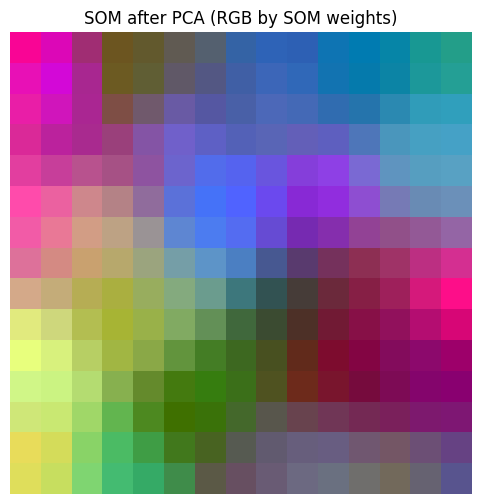

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
X_bert_pca = pca.fit_transform(X_bert)
print("✅ PCA complete，shape:", X_bert_pca.shape)

som_pca = NumbaSOM(x=15, y=15, input_len=X_bert_pca.shape[1])
print("🚀 train PCA-SOM...")
som_pca.train(X_bert_pca, num_iteration=10000)
print("✅ PCA-SOM train complete")

plot_som_rgb(som_pca, title="SOM after PCA (RGB by SOM weights)")

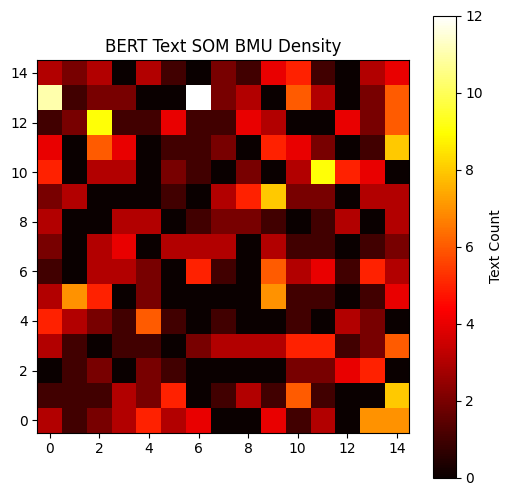

In [ ]:
def plot_bmu_density(som, X_data, title="BMU Density Map"):
    bmus = [som.winner(x) for x in X_data]
    heatmap = np.zeros((som.x, som.y))
    for i, j in bmus:
        heatmap[i, j] += 1
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap, origin='lower', cmap='hot')
    plt.title(title)
    plt.colorbar(label='Text Count')
    plt.show()

import pickle

with open(r"C:\Users\golds\Desktop\作业julian\som_text_sbert.pkl", "wb") as f:
    pickle.dump(som, f)
plot_bmu_density(som, X_bert, title="BERT Text SOM BMU Density")

🚀 开始分 epoch 训练并记录 QE/TE …


Epoch: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]

✅ 训练并记录完毕


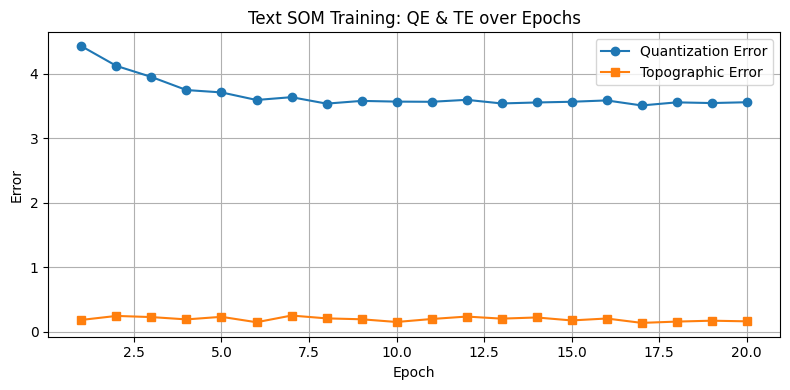

In [ ]:
from som_numba import NumbaSOM

import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

def quant_error(weights, data):
    errs = []
    for x in data:
        d = np.linalg.norm(weights - x[None,None,:], axis=2)
        i,j = np.unravel_index(np.argmin(d), d.shape)
        errs.append(np.linalg.norm(x - weights[i,j]))
    return np.mean(errs)

def topo_error(weights, data):
    h, w, _ = weights.shape
    errs = 0
    for x in data:

        dists = np.linalg.norm(weights - x[None,None,:], axis=2).reshape(-1)
        idxs = np.argsort(dists)[:2]
        b1 = (idxs[0] // w, idxs[0] % w)
        b2 = (idxs[1] // w, idxs[1] % w)
        if abs(b1[0]-b2[0]) + abs(b1[1]-b2[1]) > 1:
            errs += 1
    return errs / data.shape[0]


num_epochs   = 20
iters_per_ep = 500

qe_list = []
te_list = []


som_epoch = NumbaSOM(x=15, y=15, input_len=X_bert.shape[1])

print("🚀 start epoch train and record QE/TE …")
for ep in trange(num_epochs, desc="Epoch"):
    som_epoch.train(X_bert, num_iteration=iters_per_ep)
    qe_list.append(quant_error(som_epoch.weights, X_bert))
    te_list.append(topo_error(som_epoch.weights, X_bert))
print("✅ train complete")

epochs = np.arange(1, num_epochs+1)
plt.figure(figsize=(8,4))
plt.plot(epochs, qe_list, marker='o', label='Quantization Error')
plt.plot(epochs, te_list, marker='s', label='Topographic Error')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Text SOM Training: QE & TE over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
